In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [4]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [5]:
date = "20190815"
run_name = "08_15_2019_run_03"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [6]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [8]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [9]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [10]:
from pore_utils import raw_signal_utils
from pore_utils import smith_waterman as s_w

In [11]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [12]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [ ]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[12:31:31 - __main__] Getting molbit sequences.
[12:31:31 - __main__] Locating fastq files.
[12:31:31 - __main__] Running SW, one fastq at a time.
[12:31:31 - __main__] Starting fastq (0 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_0_0.fastq


[########################################] | 100% Completed |  1min 49.4s


[12:33:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_0_0.tsv
[12:33:21 - __main__] Starting fastq (1 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_0_1.fastq


[########################################] | 100% Completed | 56.8s


[12:34:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_0_1.tsv
[12:34:19 - __main__] Starting fastq (2 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_0_2.fastq


[########################################] | 100% Completed |  1min 13.1s


[12:35:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_0_2.tsv
[12:35:32 - __main__] Starting fastq (3 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_0_3.fastq


[########################################] | 100% Completed | 46.8s


[12:36:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_0_3.tsv
[12:36:19 - __main__] Starting fastq (4 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_1_0.fastq


[########################################] | 100% Completed |  1min 34.3s


[12:37:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_1_0.tsv
[12:37:54 - __main__] Starting fastq (5 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_1_1.fastq


[########################################] | 100% Completed | 47.2s


[12:38:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_1_1.tsv
[12:38:42 - __main__] Starting fastq (6 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_1_2.fastq


[########################################] | 100% Completed |  1min 33.3s


[12:40:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_1_2.tsv
[12:40:16 - __main__] Starting fastq (7 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_1_3.fastq


[########################################] | 100% Completed | 36.1s


[12:40:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_1_3.tsv
[12:40:52 - __main__] Starting fastq (8 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_2_0.fastq


[########################################] | 100% Completed |  1min  4.8s


[12:41:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_2_0.tsv
[12:41:58 - __main__] Starting fastq (9 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_2_1.fastq


[########################################] | 100% Completed |  1min 59.9s


[12:43:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_2_1.tsv
[12:43:58 - __main__] Starting fastq (10 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_2_2.fastq


[########################################] | 100% Completed | 38.0s


[12:44:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_2_2.tsv
[12:44:37 - __main__] Starting fastq (11 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_2_3.fastq


[########################################] | 100% Completed | 58.6s


[12:45:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_2_3.tsv
[12:45:36 - __main__] Starting fastq (12 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_3_0.fastq


[########################################] | 100% Completed |  1min 28.7s


[12:47:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_3_0.tsv
[12:47:05 - __main__] Starting fastq (13 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_3_1.fastq


[########################################] | 100% Completed |  1min 51.3s


[12:48:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_3_1.tsv
[12:48:57 - __main__] Starting fastq (14 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_3_2.fastq


[########################################] | 100% Completed |  1min 21.3s


[12:50:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_3_2.tsv
[12:50:19 - __main__] Starting fastq (15 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_3_3.fastq


[########################################] | 100% Completed |  1.8s


[12:50:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_3_3.tsv
[12:50:21 - __main__] Starting fastq (16 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_4_0.fastq


[########################################] | 100% Completed |  2min 13.2s


[12:52:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_4_0.tsv
[12:52:35 - __main__] Starting fastq (17 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_4_1.fastq


[########################################] | 100% Completed | 59.7s


[12:53:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_4_1.tsv
[12:53:36 - __main__] Starting fastq (18 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_4_2.fastq


[########################################] | 100% Completed | 39.6s


[12:54:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_4_2.tsv
[12:54:16 - __main__] Starting fastq (19 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_4_3.fastq


[########################################] | 100% Completed | 36.9s


[12:54:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_4_3.tsv
[12:54:53 - __main__] Starting fastq (20 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_5_0.fastq


[########################################] | 100% Completed |  1min 20.1s


[12:56:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_5_0.tsv
[12:56:14 - __main__] Starting fastq (21 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_5_1.fastq


[########################################] | 100% Completed |  1min 37.4s


[12:57:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_5_1.tsv
[12:57:52 - __main__] Starting fastq (22 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_5_2.fastq


[########################################] | 100% Completed | 42.2s


[12:58:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_5_2.tsv
[12:58:34 - __main__] Starting fastq (23 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_5_3.fastq


[########################################] | 100% Completed | 47.2s


[12:59:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_5_3.tsv
[12:59:22 - __main__] Starting fastq (24 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_6_0.fastq


[########################################] | 100% Completed |  1min  9.4s


[13:00:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_6_0.tsv
[13:00:32 - __main__] Starting fastq (25 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_6_1.fastq


[########################################] | 100% Completed | 57.7s


[13:01:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_6_1.tsv
[13:01:30 - __main__] Starting fastq (26 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_6_2.fastq


[########################################] | 100% Completed |  1min 23.3s


[13:02:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_6_2.tsv
[13:02:54 - __main__] Starting fastq (27 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_6_3.fastq


[########################################] | 100% Completed |  1min  3.8s


[13:03:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_6_3.tsv
[13:03:59 - __main__] Starting fastq (28 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_7_0.fastq


[########################################] | 100% Completed |  1min 58.4s


[13:05:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_7_0.tsv
[13:05:58 - __main__] Starting fastq (29 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_7_1.fastq


[########################################] | 100% Completed | 44.1s


[13:06:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_7_1.tsv
[13:06:42 - __main__] Starting fastq (30 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_7_2.fastq


[########################################] | 100% Completed |  1min 24.6s


[13:08:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_7_2.tsv
[13:08:07 - __main__] Starting fastq (31 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_7_3.fastq


[########################################] | 100% Completed | 19.8s


[13:08:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_7_3.tsv
[13:08:27 - __main__] Starting fastq (32 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_8_0.fastq


[########################################] | 100% Completed |  1min 52.3s


[13:10:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_8_0.tsv
[13:10:20 - __main__] Starting fastq (33 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_8_1.fastq


[########################################] | 100% Completed | 39.1s


[13:10:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_8_1.tsv
[13:11:00 - __main__] Starting fastq (34 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_8_2.fastq


[########################################] | 100% Completed |  1min 15.6s


[13:12:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_8_2.tsv
[13:12:16 - __main__] Starting fastq (35 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_8_3.fastq


[########################################] | 100% Completed | 33.8s


[13:12:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_8_3.tsv
[13:12:50 - __main__] Starting fastq (36 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_9_0.fastq


[########################################] | 100% Completed |  1min  7.5s


[13:13:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_9_0.tsv
[13:13:58 - __main__] Starting fastq (37 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_9_1.fastq


[########################################] | 100% Completed | 53.3s


[13:14:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_9_1.tsv
[13:14:51 - __main__] Starting fastq (38 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_9_2.fastq


[########################################] | 100% Completed |  1min 40.8s


[13:16:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_9_2.tsv
[13:16:33 - __main__] Starting fastq (39 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_9_3.fastq


[########################################] | 100% Completed | 39.2s


[13:17:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_9_3.tsv
[13:17:12 - __main__] Starting fastq (40 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_10_0.fastq


[########################################] | 100% Completed |  2min  6.2s


[13:19:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_10_0.tsv
[13:19:19 - __main__] Starting fastq (41 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_10_1.fastq


[########################################] | 100% Completed | 44.2s


[13:20:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_10_1.tsv
[13:20:03 - __main__] Starting fastq (42 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_10_2.fastq


[########################################] | 100% Completed |  1min 11.1s


[13:21:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_10_2.tsv
[13:21:15 - __main__] Starting fastq (43 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_10_3.fastq


[########################################] | 100% Completed | 12.8s


[13:21:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_10_3.tsv
[13:21:28 - __main__] Starting fastq (44 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_11_0.fastq


[########################################] | 100% Completed |  1min  4.8s


[13:22:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_11_0.tsv
[13:22:33 - __main__] Starting fastq (45 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_11_1.fastq


[########################################] | 100% Completed |  1min 28.8s


[13:24:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_11_1.tsv
[13:24:03 - __main__] Starting fastq (46 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_11_2.fastq


[########################################] | 100% Completed |  1min 10.5s


[13:25:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_11_2.tsv
[13:25:14 - __main__] Starting fastq (47 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_11_3.fastq


[########################################] | 100% Completed | 25.0s


[13:25:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_11_3.tsv
[13:25:39 - __main__] Starting fastq (48 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_12_0.fastq


[########################################] | 100% Completed | 48.5s


[13:26:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_12_0.tsv
[13:26:28 - __main__] Starting fastq (49 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_12_1.fastq


[########################################] | 100% Completed |  1min 46.3s


[13:28:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_12_1.tsv
[13:28:15 - __main__] Starting fastq (50 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_12_2.fastq


[########################################] | 100% Completed | 50.9s


[13:29:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_12_2.tsv
[13:29:06 - __main__] Starting fastq (51 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_12_3.fastq


[########################################] | 100% Completed | 47.1s


[13:29:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_12_3.tsv
[13:29:53 - __main__] Starting fastq (52 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_13_0.fastq


[########################################] | 100% Completed |  1min  3.8s


[13:30:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_13_0.tsv
[13:30:58 - __main__] Starting fastq (53 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_13_1.fastq


[########################################] | 100% Completed | 55.0s


[13:31:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_13_1.tsv
[13:31:53 - __main__] Starting fastq (54 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_13_2.fastq


[########################################] | 100% Completed | 50.8s


[13:32:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_13_2.tsv
[13:32:44 - __main__] Starting fastq (55 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_13_3.fastq


[########################################] | 100% Completed |  1min  6.6s


[13:33:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_13_3.tsv
[13:33:52 - __main__] Starting fastq (56 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_14_0.fastq


[########################################] | 100% Completed |  1min  5.6s


[13:34:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_14_0.tsv
[13:34:58 - __main__] Starting fastq (57 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_14_1.fastq


[########################################] | 100% Completed |  1min  6.4s


[13:36:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_14_1.tsv
[13:36:04 - __main__] Starting fastq (58 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_14_2.fastq


[########################################] | 100% Completed | 54.6s


[13:36:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_14_2.tsv
[13:36:59 - __main__] Starting fastq (59 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_14_3.fastq


[########################################] | 100% Completed |  1min  3.0s


[13:38:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_14_3.tsv
[13:38:03 - __main__] Starting fastq (60 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_15_0.fastq


[########################################] | 100% Completed | 52.6s


[13:38:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_15_0.tsv
[13:38:56 - __main__] Starting fastq (61 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_15_1.fastq


[########################################] | 100% Completed |  1min 12.1s


[13:40:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_15_1.tsv
[13:40:08 - __main__] Starting fastq (62 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_15_2.fastq


[########################################] | 100% Completed |  1min  7.6s


[13:41:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_15_2.tsv
[13:41:17 - __main__] Starting fastq (63 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_15_3.fastq


[########################################] | 100% Completed |  1min  8.9s


[13:42:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_15_3.tsv
[13:42:26 - __main__] Starting fastq (64 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_16_0.fastq


[########################################] | 100% Completed |  1min  6.7s


[13:43:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_16_0.tsv
[13:43:33 - __main__] Starting fastq (65 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_16_1.fastq


[########################################] | 100% Completed |  1min  5.4s


[13:44:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_16_1.tsv
[13:44:39 - __main__] Starting fastq (66 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_16_2.fastq


[########################################] | 100% Completed | 49.1s


[13:45:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_16_2.tsv
[13:45:29 - __main__] Starting fastq (67 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_16_3.fastq


[########################################] | 100% Completed |  1min 32.2s


[13:47:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_16_3.tsv
[13:47:01 - __main__] Starting fastq (68 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_17_0.fastq


[########################################] | 100% Completed |  1min  0.1s


[13:48:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_17_0.tsv
[13:48:02 - __main__] Starting fastq (69 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_17_1.fastq


[########################################] | 100% Completed |  1min  0.2s


[13:49:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_17_1.tsv
[13:49:03 - __main__] Starting fastq (70 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_17_2.fastq


[########################################] | 100% Completed | 55.7s


[13:49:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_17_2.tsv
[13:49:59 - __main__] Starting fastq (71 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_17_3.fastq


[########################################] | 100% Completed |  1min 11.8s


[13:51:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_17_3.tsv
[13:51:11 - __main__] Starting fastq (72 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_18_0.fastq


[########################################] | 100% Completed |  1min  9.9s


[13:52:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_18_0.tsv
[13:52:21 - __main__] Starting fastq (73 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_18_1.fastq


[########################################] | 100% Completed | 51.1s


[13:53:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_18_1.tsv
[13:53:13 - __main__] Starting fastq (74 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_18_2.fastq


[########################################] | 100% Completed | 44.2s


[13:53:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_18_2.tsv
[13:53:57 - __main__] Starting fastq (75 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_18_3.fastq


[########################################] | 100% Completed |  1min 17.1s


[13:55:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_18_3.tsv
[13:55:15 - __main__] Starting fastq (76 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_19_0.fastq


[########################################] | 100% Completed |  1min 17.0s


[13:56:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_19_0.tsv
[13:56:32 - __main__] Starting fastq (77 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_19_1.fastq


[########################################] | 100% Completed |  1min 16.7s


[13:57:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_19_1.tsv
[13:57:49 - __main__] Starting fastq (78 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_19_2.fastq


[########################################] | 100% Completed |  1min 26.9s


[13:59:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_19_2.tsv
[13:59:17 - __main__] Starting fastq (79 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_19_3.fastq


[########################################] | 100% Completed | 16.3s


[13:59:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_19_3.tsv
[13:59:33 - __main__] Starting fastq (80 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_20_0.fastq


[########################################] | 100% Completed |  1min 31.8s


[14:01:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_20_0.tsv
[14:01:06 - __main__] Starting fastq (81 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_20_1.fastq


[########################################] | 100% Completed | 51.8s


[14:01:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_20_1.tsv
[14:01:58 - __main__] Starting fastq (82 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_20_2.fastq


[########################################] | 100% Completed | 43.8s


[14:02:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_20_2.tsv
[14:02:42 - __main__] Starting fastq (83 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_20_3.fastq


[########################################] | 100% Completed | 57.5s


[14:03:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_20_3.tsv
[14:03:40 - __main__] Starting fastq (84 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_21_0.fastq


[########################################] | 100% Completed |  1min 21.0s


[14:05:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_21_0.tsv
[14:05:01 - __main__] Starting fastq (85 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_21_1.fastq


[########################################] | 100% Completed |  1min 12.8s


[14:06:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_21_1.tsv
[14:06:15 - __main__] Starting fastq (86 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_21_2.fastq


[########################################] | 100% Completed | 45.1s


[14:07:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_21_2.tsv
[14:07:00 - __main__] Starting fastq (87 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_21_3.fastq


[########################################] | 100% Completed | 44.6s


[14:07:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_21_3.tsv
[14:07:45 - __main__] Starting fastq (88 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_22_0.fastq


[########################################] | 100% Completed | 41.6s


[14:08:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_22_0.tsv
[14:08:27 - __main__] Starting fastq (89 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_22_1.fastq


[########################################] | 100% Completed |  1min 36.0s


[14:10:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_22_1.tsv
[14:10:04 - __main__] Starting fastq (90 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_22_2.fastq


[########################################] | 100% Completed | 55.9s


[14:11:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_22_2.tsv
[14:11:00 - __main__] Starting fastq (91 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_22_3.fastq


[########################################] | 100% Completed | 58.2s


[14:11:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_22_3.tsv
[14:11:59 - __main__] Starting fastq (92 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_23_0.fastq


[########################################] | 100% Completed | 41.1s


[14:12:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_23_0.tsv
[14:12:40 - __main__] Starting fastq (93 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_23_1.fastq


[########################################] | 100% Completed |  1min 22.3s


[14:14:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_23_1.tsv
[14:14:03 - __main__] Starting fastq (94 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_23_2.fastq


[########################################] | 100% Completed |  1min 27.4s


[14:15:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_23_2.tsv
[14:15:31 - __main__] Starting fastq (95 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_23_3.fastq


[########################################] | 100% Completed | 46.5s


[14:16:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_23_3.tsv
[14:16:18 - __main__] Starting fastq (96 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_24_0.fastq


[########################################] | 100% Completed | 45.8s


[14:17:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_24_0.tsv
[14:17:04 - __main__] Starting fastq (97 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_24_1.fastq


[########################################] | 100% Completed |  1min 25.2s


[14:18:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_24_1.tsv
[14:18:30 - __main__] Starting fastq (98 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_24_2.fastq


[########################################] | 100% Completed | 41.4s


[14:19:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_24_2.tsv
[14:19:12 - __main__] Starting fastq (99 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_24_3.fastq


[########################################] | 100% Completed |  1min 21.1s


[14:20:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_24_3.tsv
[14:20:33 - __main__] Starting fastq (100 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_25_0.fastq


[########################################] | 100% Completed |  1min 38.6s


[14:22:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_25_0.tsv
[14:22:12 - __main__] Starting fastq (101 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_25_1.fastq


[########################################] | 100% Completed | 53.2s


[14:23:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_25_1.tsv
[14:23:06 - __main__] Starting fastq (102 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_25_2.fastq


[########################################] | 100% Completed | 29.0s


[14:23:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_25_2.tsv
[14:23:35 - __main__] Starting fastq (103 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_25_3.fastq


[########################################] | 100% Completed | 56.6s


[14:24:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_25_3.tsv
[14:24:32 - __main__] Starting fastq (104 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_26_0.fastq


[########################################] | 100% Completed | 51.2s


[14:25:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_26_0.tsv
[14:25:24 - __main__] Starting fastq (105 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_26_1.fastq


[########################################] | 100% Completed |  1min 32.8s


[14:26:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_26_1.tsv
[14:26:57 - __main__] Starting fastq (106 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_26_2.fastq


[########################################] | 100% Completed |  1min 10.6s


[14:28:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_26_2.tsv
[14:28:08 - __main__] Starting fastq (107 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_26_3.fastq


[########################################] | 100% Completed | 38.1s


[14:28:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_26_3.tsv
[14:28:47 - __main__] Starting fastq (108 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_27_0.fastq


[########################################] | 100% Completed |  2min 17.9s


[14:31:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_27_0.tsv
[14:31:05 - __main__] Starting fastq (109 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_27_1.fastq


[########################################] | 100% Completed | 44.3s


[14:31:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_27_1.tsv
[14:31:50 - __main__] Starting fastq (110 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_27_2.fastq


[########################################] | 100% Completed |  1min  2.8s


[14:32:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_27_2.tsv
[14:32:54 - __main__] Starting fastq (111 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_27_3.fastq


[########################################] | 100% Completed |  2.9s


[14:32:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_27_3.tsv
[14:32:57 - __main__] Starting fastq (112 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_28_0.fastq


[########################################] | 100% Completed |  1min 27.4s


[14:34:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_28_0.tsv
[14:34:25 - __main__] Starting fastq (113 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_28_1.fastq


[########################################] | 100% Completed |  1min  5.2s


[14:35:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_28_1.tsv
[14:35:30 - __main__] Starting fastq (114 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_28_2.fastq


[########################################] | 100% Completed |  1min 12.1s


[14:36:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_28_2.tsv
[14:36:43 - __main__] Starting fastq (115 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_29_0.fastq


[########################################] | 100% Completed |  1min 28.0s


[14:38:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_29_0.tsv
[14:38:11 - __main__] Starting fastq (116 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_28_3.fastq


[########################################] | 100% Completed | 21.0s


[14:38:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_28_3.tsv
[14:38:33 - __main__] Starting fastq (117 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_29_1.fastq


[########################################] | 100% Completed | 54.4s


[14:39:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_29_1.tsv
[14:39:28 - __main__] Starting fastq (118 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_29_2.fastq


[########################################] | 100% Completed | 46.4s


[14:40:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_29_2.tsv
[14:40:14 - __main__] Starting fastq (119 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_29_3.fastq


[########################################] | 100% Completed |  1min 10.9s


[14:41:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_29_3.tsv
[14:41:26 - __main__] Starting fastq (120 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_30_0.fastq


[########################################] | 100% Completed |  1min  7.6s


[14:42:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_30_0.tsv
[14:42:34 - __main__] Starting fastq (121 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_30_1.fastq


[########################################] | 100% Completed | 33.4s


[14:43:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_30_1.tsv
[14:43:08 - __main__] Starting fastq (122 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_30_2.fastq


[########################################] | 100% Completed |  1min 45.6s


[14:44:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_30_2.tsv
[14:44:54 - __main__] Starting fastq (123 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_30_3.fastq


[########################################] | 100% Completed | 50.9s


[14:45:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_30_3.tsv
[14:45:45 - __main__] Starting fastq (124 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_31_0.fastq


[########################################] | 100% Completed |  1min 12.9s


[14:46:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_31_0.tsv
[14:46:58 - __main__] Starting fastq (125 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_31_1.fastq


[########################################] | 100% Completed |  1min 37.3s


[14:48:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_31_1.tsv
[14:48:36 - __main__] Starting fastq (126 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_31_2.fastq


[########################################] | 100% Completed |  1min  1.4s


[14:49:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_31_2.tsv
[14:49:38 - __main__] Starting fastq (127 of 315)
	/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/pass/fastq_runid_3af76ac4a3c3302724a333ac8c108c258c9ceb0d_31_3.fastq


[                                        ] | 0% Completed |  6.3s

In [45]:
sw_list = []
for fname in os.listdir(sw_dir):
    if "all" in fname:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [46]:
sw_arr = np.array(sw)

In [47]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

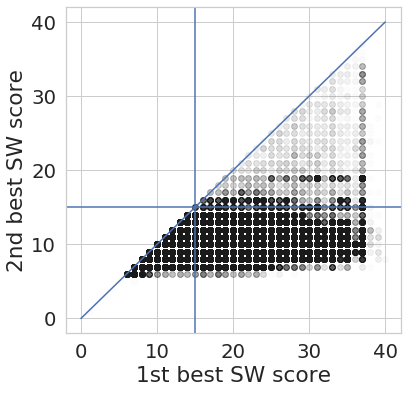

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

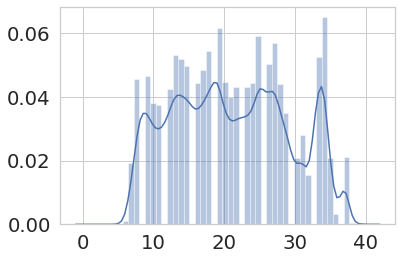

In [49]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [50]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [51]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [52]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [53]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190815/guppy_3.2.2_08_15_2019_run_03_exec_20190816/sw/all_3af76ac4a3c3302724a333ac8c108c258c9ceb0d.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [54]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.split(", ")

In [55]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

4
['64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79']
['80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79']


## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [56]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [57]:
len(accept_molbit)

276369

In [58]:
sum(accept_molbit)

204007

In [59]:
sum(accept_molbit) / len(accept_molbit)

0.7381688973799522

## Extract the best-aligned molbit, across ONLY the extant molbits

In [91]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [92]:
extant_sw = sw.loc[:, extant_sw_cols]

In [93]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [94]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [95]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [96]:
n_extant_is_best

203270

Percentage of well-aligned reads that belong to the true set

In [97]:
n_extant_is_best/len(sw_accepted)

0.9963873788644507

Read counts for each molbit

In [98]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('64', 9),
 ('65', 137),
 ('66', 312),
 ('67', 165),
 ('68', 226),
 ('69', 86),
 ('70', 80),
 ('71', 156),
 ('72', 236),
 ('73', 185),
 ('74', 542),
 ('75', 269),
 ('76', 73),
 ('77', 165),
 ('78', 56),
 ('79', 91),
 ('80', 11622),
 ('81', 14828),
 ('82', 5530),
 ('83', 3539),
 ('84', 5147),
 ('85', 12759),
 ('86', 16156),
 ('87', 7468),
 ('88', 3569),
 ('89', 75471),
 ('90', 9785),
 ('91', 1739),
 ('92', 14428),
 ('93', 6767),
 ('94', 5335),
 ('95', 7076)]

In [99]:
print("\n".join([str(x) for x in c]))

9
137
312
165
226
86
80
156
236
185
542
269
73
165
56
91
11622
14828
5530
3539
5147
12759
16156
7468
3569
75471
9785
1739
14428
6767
5335
7076


## Extract the best-aligned molbit, across ONLY the current run's molbits

In [83]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [84]:
extant_sw = sw.loc[:, extant_sw_cols]

In [85]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [86]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [87]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [88]:
n_extant_is_best

200563

Percentage of well-aligned reads that belong to the true set

In [89]:
n_extant_is_best/len(sw_accepted)

0.9831182263353708

Read counts for each molbit

In [90]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('80', 11683),
 ('81', 15008),
 ('82', 5976),
 ('83', 3584),
 ('84', 5204),
 ('85', 12878),
 ('86', 16207),
 ('87', 7555),
 ('88', 3641),
 ('89', 75648),
 ('90', 9883),
 ('91', 2259),
 ('92', 14747),
 ('93', 6832),
 ('94', 5694),
 ('95', 7208)]

## Get counts for all molbits

In [100]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

0
0
7
0
0
0
0
214
5
10
0
2
2
52
1
6
1
2
0
0
0
0
4
0
0
0
0
10
0
4
3
0
0
0
0
3
51
22
0
0
0
0
0
108
0
0
0
2
0
15
0
1
3
1
6
0
1
0
175
0
1
0
1
0
9
136
310
162
226
86
80
156
234
184
543
266
42
159
56
82
11521
14826
5499
3538
5146
12708
16156
7416
3568
75466
9784
1680
14104
6765
5312
7074
